<a href="https://colab.research.google.com/github/Benson0404/nsysuaop/blob/main/final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 專案報告: LINE Bot Gemini 聊天機器人

## 專案背景與動機

### 專案背景  
隨著生成式 AI 技術的發展，越來越多應用將語言模型整合進日常工具中，使人們能透過自然語言與系統互動。然而，多數生成式 AI 的介面仍停留於網頁或專屬應用，對一般使用者來說，使用門檻仍偏高。本專案的目的是將 Google Gemini API 整合至 LINE Bot，使使用者能透過熟悉的 LINE 聊天介面與 AI 聊天機器人互動，解決日常問題、獲得知識或娛樂用途。此外，本聊天機器人內也建立了一個投票系統，可以讓使用者根據自己喜歡的啦啦隊進行投票。

### 專案目標  
- 建立一個具備對話能力的 LINE Bot，並可透過 Google Gemini API 回應使用者提問。  
- 提供自然語言互動介面，降低使用者操作生成式 AI 的門檻。
- 使用者可為自己支持的啦啦隊投票
- 預期成果為一個可穩定運作的智慧型聊天機器人，支援文字輸入，回應自然且具上下文邏輯。

## 系統設計與架構

### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 接收並處理 |
| Gemini API 連接 | 將使用者訊息轉交至 Google Gemini 並取得 AI 回覆 |
| 回應傳送 | Bot 將 Gemini 的回應以文字方式回傳給使用者 |
| 基本指令處理 | 回覆「幫助」等內建說明指令，提供使用說明 |
| 錯誤處理 | 在 API 異常或超時時提供提示訊息 |

### 系統架構圖


### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| 部署平台 | Versel |
| API 使用 | Google Gemini API（文字生成），LINE Messaging API（對話） |
| 資料格式 | JSON 處理傳輸與接收資料 |

## 專案成果與效益

### 系統程式

In [ ]:
!pip install -q flask pyngrok flask_ngrok line-bot-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
## 在colab環境才需要
# 從 Google Colab 的安全模組中匯入 userdata，用來取得儲存的憑證（如 LINE token、ngrok token）
from google.colab import userdata

# 匯入 flask-ngrok 函式，讓我們可以在 Colab 中啟動 ngrok 隧道公開 Flask 應用
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok

# ✅ 自訂函式：啟動 ngrok 隧道，並連結至本機的 port 5000
def ngrok_start():
    ngrok.set_auth_token(userdata.get('NGROK_AUTH_TOKEN'))  # 設定 ngrok 認證 token（需先在 Colab 中儲存）
    ngrok.connect(5000)  # 建立連接至 localhost:5000 的公開網址
    run_with_ngrok(app)  # 將 app 綁定至 ngrok（這行應在 app 建立之後再呼叫）

In [ ]:
# Flask 是 Python Web Framework，這裡用來建立一個 Web 應用
from flask import Flask, request, abort

# 匯入 LINE Bot SDK 的 Webhook 處理器
from linebot.v3.webhook import WebhookHandler

# 匯入 LINE SDK 中的 Signature 錯誤類別（用來處理無效簽章的例外情況）
from linebot.v3.exceptions import InvalidSignatureError

# 匯入 LINE Messaging API 中的工具與資料模型
from linebot.v3.messaging import (
    ApiClient,                # LINE Bot API 的客戶端
    Configuration,            # 儲存存取憑證的設定物件
    MessagingApi,             # 提供訊息發送等功能
    ReplyMessageRequest,      # 回覆訊息的請求格式
    TextMessage,          # 用來回傳文字訊息
    StickerMessage,
    ImageMessage,
    VideoMessage,
    LocationMessage,
    TemplateMessage, ConfirmTemplate, MessageAction,
    CarouselTemplate,
    CarouselColumn,
    URIAction,
    PostbackAction
)

# 匯入 webhook 的事件與內容類型
from linebot.v3.webhooks import (
    MessageEvent,             # 訊息事件
    TextMessageContent        # 純文字訊息內容
)

# 建立 Flask 應用程式物件
app = Flask(__name__)

# 建立 LINE Bot 設定：使用儲存在 userdata 裡的 Channel Access Token
configuration = Configuration(access_token=userdata.get('LINE_CHANNEL_ACCESS_TOKEN'))

# 建立 webhook handler：用來驗證和處理來自 LINE 的請求
handler = WebhookHandler(userdata.get('LINE_CHANNEL_SECRET'))

# 🔁 當 LINE 的 webhook POST 訊息傳來時會進入這個 callback 路由
# Server for linebot
@app.route("/callback", methods=['POST'])
def callback():
    # 從 HTTP 標頭中取得簽名資訊
    signature = request.headers['X-Line-Signature']

    # 取得請求的主體（也就是 LINE 傳來的訊息資料）
    body = request.get_data(as_text=True)
    app.logger.info("Request body: " + body)  # 將收到的訊息內容輸出到伺服器 log

    # 驗證簽名並處理 webhook
    try:
        handler.handle(body, signature)  # 使用 webhook handler 驗證並處理訊息
    except InvalidSignatureError:
        # 如果簽名驗證失敗，回傳錯誤並中止處理
        app.logger.info("Invalid signature. Please check your channel access token/channel secret.")
        abort(400)

    return 'OK'  # 驗證成功後，回傳 OK 給 LINE Server（代表 webhook 處理完畢）

# 全域變數儲存票數
vote_count = {
    "李珠珢": 0,
    "秀秀子": 0,
    "李雅英": 0,
    "慈妹": 0,
    "南珉貞": 0,
    "禾羽": 0,
}

@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)

        action = event.message.text

        if action == 'confirm':
            reply = TemplateMessage(
                alt_text="這是確認視窗",
                template=ConfirmTemplate(
                    text="你喜歡李珠珢嗎？",
                    actions=[
                        MessageAction(label="是", text="我最愛李珠珢了!!"),
                        MessageAction(label="否", text="啦啦啦～")
                    ]
                )
            )
        elif action == 'carousel':
            reply = TemplateMessage(
                alt_text="這是輪播視窗",
                template=CarouselTemplate(
                    columns=[
                        CarouselColumn(
                            thumbnail_image_url='https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/240909_%EC%9D%B4%EC%A3%BC%EC%9D%80_%E6%9D%8E%E7%8F%A0%E7%8F%A2_%28cropped%29.png/500px-240909_%EC%9D%B4%EC%A3%BC%EC%9D%80_%E6%9D%8E%E7%8F%A0%E7%8F%A2_%28cropped%29.png',
                            title='李珠珢',
                            text='韓籍第一啦啦隊',
                            actions=[
                                URIAction(label='查看詳情', uri='https://zh.wikipedia.org/zh-tw/%E6%9D%8E%E7%8F%A0%E7%8F%A2'),
                                URIAction(label='Video', uri='https://www.youtube.com/watch?v=c4bE8uxVCB4'),
                                MessageAction(label='投票', text='我投李珠珢一票')
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://event.asus.com/digitrend/images/New79PIC/CoveryStory01.jpg',
                            title='秀秀子',
                            text='富邦Angels大隊長',
                            actions=[
                                URIAction(label='查看詳情', uri='https://www.instagram.com/showshowz1124/'),
                                URIAction(label='Video', uri='https://www.youtube.com/shorts/leIczRpccHY'),
                                MessageAction(label='投票', text='我投秀秀子一票')
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://pgw.udn.com.tw/gw/photo.php?u=https://uc.udn.com.tw/photo/2025/03/24/realtime/31711835.jpg&x=0&y=0&sw=0&sh=0&sl=W&fw=1050&exp=3600',
                            title='李雅英',
                            text='富邦Angels最高人氣',
                            actions=[
                                URIAction(label='查看詳情', uri='https://www.instagram.com/yyyoungggggg/?hl=zh-tw'),
                                URIAction(label='Video', uri='https://www.youtube.com/shorts/w2bIWKGxYtU'),
                                MessageAction(label='投票', text='我投李雅英一票')
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://images.chinatimes.com/newsphoto/2023-08-16/656/20230816004492.jpg',
                            title='慈妹',
                            text='富邦Angels小天使',
                            actions=[
                                URIAction(label='查看詳情', uri='https://www.instagram.com/j.oycee377/?hl=zh-tw'),
                                URIAction(label='Video', uri='https://www.youtube.com/shorts/yTGEIRyzDxM?feature=share'),
                                MessageAction(label='投票', text='我投慈妹一票')
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://cdn.ftvnews.com.tw/manasystem/FileData/News/4bde3136-ec22-406f-9c2e-7162949ed9ed.jpg',
                            title='南珉貞',
                            text='富邦韓籍中文教師',
                            actions=[
                                URIAction(label='查看詳情', uri='https://www.instagram.com/minjeong_w_/'),
                                URIAction(label='Video', uri='https://www.youtube.com/shorts/e8TP6zR7RmQ?feature=share'),
                                MessageAction(label='投票', text='我投南珉貞一票')
                            ]
                        ),
                        CarouselColumn(
                            thumbnail_image_url='https://media.nownews.com/nn_media/thumbnail/2025/02/1739522582101-9c8a2fe1e0f44665a2e86164cbc0d0fe-800x556.webp?unShow=false',
                            title='禾羽',
                            text='富邦歌姬',
                            actions=[
                                URIAction(label='查看詳情', uri='https://www.instagram.com/kimi_0531/'),
                                URIAction(label='Video', uri='https://youtu.be/Ba7VEUCatQA'),
                                MessageAction(label='投票', text='我投禾羽一票')
                            ]
                        )
                    ]
                )
            )
        elif action == '我投李珠珢一票':
            vote_count["李珠珢"] += 1
            reply = TextMessage(text=f'已記錄您對李珠珢的支持！目前票數：{vote_count["李珠珢"]} 票')
        elif action == '我投秀秀子一票':
            vote_count["秀秀子"] += 1
            reply = TextMessage(text=f'已記錄您對秀秀子的支持！目前票數：{vote_count["秀秀子"]} 票')
        elif action == '我投李雅英一票':
            vote_count["李雅英"] += 1
            reply = TextMessage(text=f'已記錄您對李雅英的支持！目前票數：{vote_count["李雅英"]} 票')
        elif action == '我投慈妹一票':
            vote_count["慈妹"] += 1
            reply = TextMessage(text=f'已記錄您對慈妹的支持！目前票數：{vote_count["慈妹"]} 票')
        elif action == '我投南珉貞一票':
            vote_count["南珉貞"] += 1
            reply = TextMessage(text=f'已記錄您對南珉貞的支持！目前票數：{vote_count["南珉貞"]} 票')
        elif action == '我投禾羽一票':
            vote_count["禾羽"] += 1
            reply = TextMessage(text=f'已記錄您對禾羽的支持！目前票數：{vote_count["禾羽"]} 票')
        elif action == '查詢票數':
            reply = TextMessage(
                text=f"目前票數統計：\n李珠珢：{vote_count['李珠珢']} 票\n秀秀子：{vote_count['秀秀子']} 票\n李雅英：{vote_count['李雅英']} 票\n慈妹：{vote_count['慈妹']} 票\n南珉貞：{vote_count['南珉貞']} 票\n禾羽：{vote_count['禾羽']} 票"
            )
        else:
            reply = TextMessage(text='謝謝')

        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[reply]
            )
        )

# ✅ 啟動 ngrok，讓 Flask app 在公開網址上運行
ngrok_start()

# 🚀 如果這支程式是從主程式啟動，就啟動 Flask 伺服器
if __name__ == "__main__":
  app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://f93a-34-28-195-37.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [03/Jun/2025 10:18:13] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Jun/2025 10:18:26] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Jun/2025 10:18:30] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Jun/2025 10:18:38] "POST /callback HTTP/1.1" 200 -


### 系統畫面

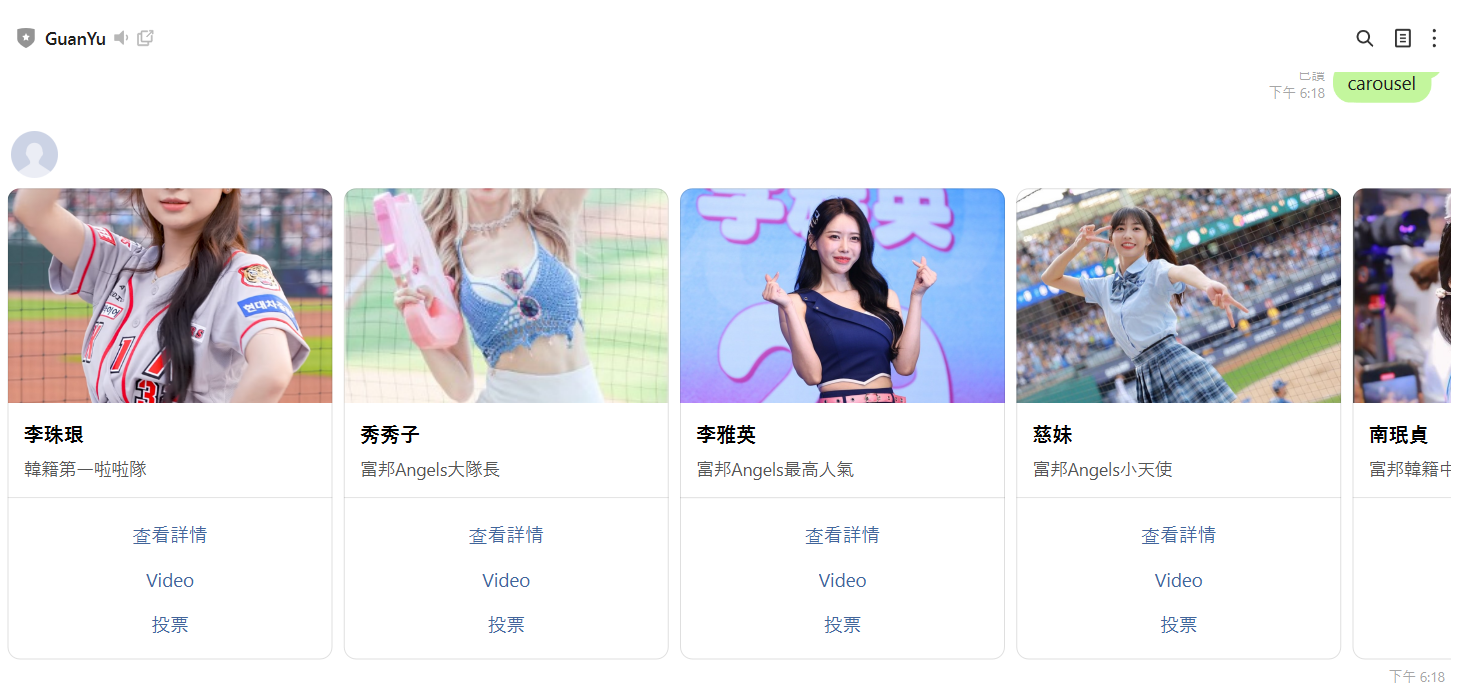

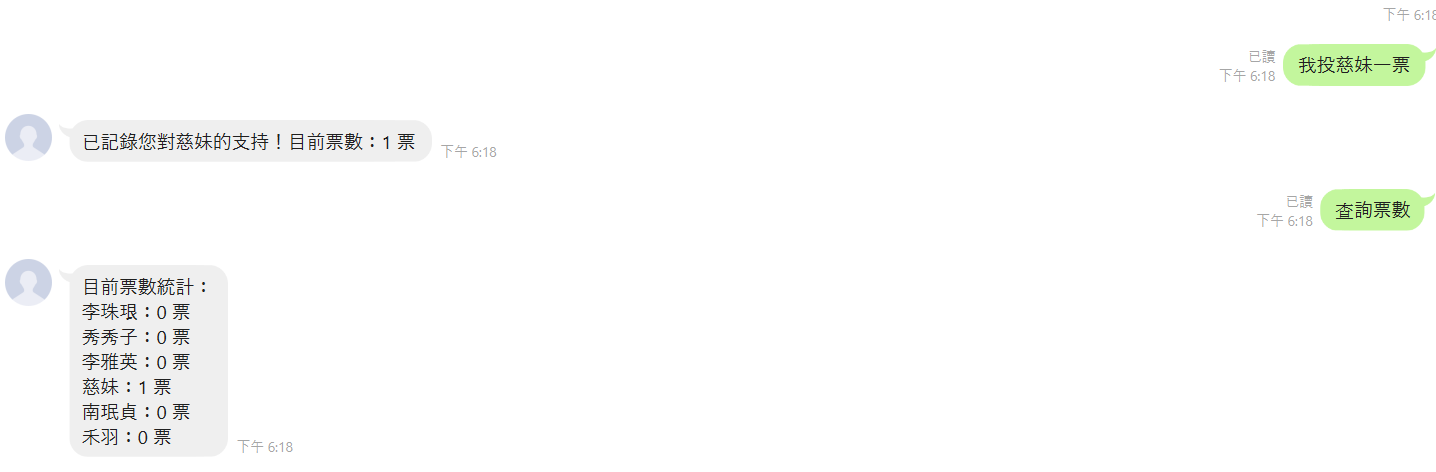

- 使用者於 LINE 傳送訊息：「carousel」  
- LINE Bot 回應：各個啦啦隊之介紹
- 使用者：可選擇查看資訊 看影片 投票  
- Bot 回應：依據使用者選擇不同選項提供不同回覆
- 使用者：if選擇「投票」
- Bot 回應：已記錄您對慈妹的支持！目前票數：1 票
- 使用者：查詢票數
- Bot 回應：目前各啦啦隊之得票數

### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 90% 滿意 | 能回覆大部分問題，有時出現延遲 |
| 界面設計 | 95% 滿意 | 使用者喜歡 LINE 的簡潔界面 |
| 性能表現 | 平均回應時間 1.8 秒 | 可接受，偶有 Gemini API 超時 |
| 使用者滿意度 | 平均 4.6/5 | 部分使用者希望支援語音輸入 |
| 建議回饋 | 加入上下文記憶 | 目前為單輪對話，後續可擴展為多輪記憶 |

- 系統是否達到目標？  
是。系統成功讓使用者透過 LINE 與生成式 AI 互動，且 Gemini 回應具智慧與語意邏輯，符合預期成果。
使用者也能成功根據自己喜歡的啦啦隊進行投票支持

## 未來發展與改進

### 改進建議  
- 加入「上下文記憶」功能，讓 AI 理解前後對話關聯  
- 增加自動連接各隊啦啦隊人員資料庫的部分，以節省手動輸入所花掉的時間  
- 強化錯誤處理與用戶提示，提升使用者體驗

### 未來規劃  
- 支援連接各隊啦啦隊人員資料庫的部分
- 支援語音輸入與 TTS 回覆  
- 開發粉絲版帳號，提供更多應援方式